In [28]:
# CSC396 - Intro to Deep Learning w/ NLP
# Claire Lynch & Jose Santiago Campa Morales
# Final Project
# Hate Speech and Offensive Language Classifier

import random
import torch
import transformers
import inspect
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score

# enable tqdm in pandas
tqdm.pandas()

# set to True to use the gpu (if there is one available)
use_gpu = True

# select device
device = torch.device('cuda' if use_gpu and torch.cuda.is_available() else 'cpu')
print(f'device: {device.type}')

# random seed
seed = 1234

# versions
print(f'torch version: {torch.__version__}')
print(f'transformers version: {transformers.__version__}')
print(f'transformers file: {transformers.__file__}')
#print(inspect.signature(TrainingArguments))

# set random seed
if seed is not None:
    print(f'random seed: {seed}')
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

device: cuda
torch version: 2.5.1+cu121
transformers version: 4.56.2
transformers file: C:\Users\jscm1\anaconda3\envs\csc396-gpu\lib\site-packages\transformers\__init__.py
random seed: 1234


In [29]:
# 1. Work on dataset
# Load dataset
file_path = "data/labeled_data.csv"
train_df = pd.read_csv(file_path)

train_df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [30]:
# Only use tweet and class columns
# Original: # [count, hate_speech, offensive_language, neither, class, tweet]
train_df = train_df[['class', 'tweet']].copy()

# Map classes to labels
label_map = {
    0: "hate_speech",
    1: "offensive_language",
    2: "neither"
}

train_df['label'] = train_df['class'].map(label_map)
train_df = train_df[['class', 'label', 'tweet']]

train_df

,class,label,tweet
0,2,neither,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,offensive_language,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,offensive_language,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,offensive_language,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,offensive_language,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...
24778,1,offensive_language,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,2,neither,"you've gone and broke the wrong heart baby, an..."
24780,1,offensive_language,young buck wanna eat!!.. dat nigguh like I ain...
24781,1,offensive_language,youu got wild bitches tellin you lies


In [31]:
# Samples
print("\nSample tweets:")
print(train_df.sample(10))


Sample tweets:
       class               label  \
9236       1  offensive_language   
1022       1  offensive_language   
2785       2             neither   
20895      1  offensive_language   
12505      1  offensive_language   
2301       2             neither   
608        1  offensive_language   
15019      1  offensive_language   
16696      1  offensive_language   
1209       2             neither   

                                                   tweet  
9236   Fuck all y'all hoes &#128567; gang shit &#1281...  
1022   &#128530;RT @SedSince81: niggers RT @VonshayeB...  
2785   @Carxlito PS3 and case is still in the trash c...  
20895                 Smellin good, bitches wanna hug me  
12505                                   Lmao this bitch.  
2301   @0xabad1dea Hard to QA? Time is also a pain to...  
608    "You can take someone out of the ghetto, but y...  
15019  RT @DomBeets: I wish someone would make a song...  
16696  RT @NorrisDaGod: I ain't never had a basic bit...

In [32]:
# Basic Stats
print("\nLabel distribution:")
print(train_df['label'].value_counts())


Label distribution:
label
offensive_language    19190
neither                4163
hate_speech            1430
Name: count, dtype: int64


C:\Users\jscm1\AppData\Local\Temp\ipykernel_52980\2267843281.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(train_df['label']).plot.bar()


<Axes: xlabel='label'>

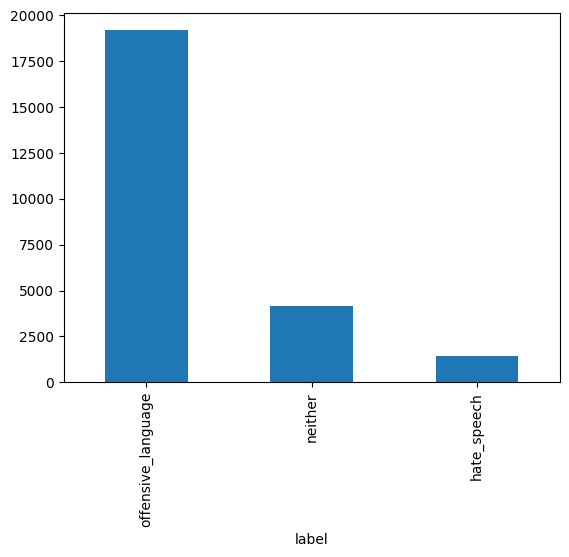

In [33]:
pd.value_counts(train_df['label']).plot.bar()

In [34]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['tweet'].tolist(),
    train_df['class'].tolist(),
    test_size=0.2,
    random_state=16
)

In [35]:
# Pretrained model from Hugging Face
model_name = "GroNLP/hateBERT"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/hateBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=128)

train_dataset = Dataset.from_dict({'text': train_texts, 'label': train_labels})
val_dataset = Dataset.from_dict({'text': val_texts, 'label': val_labels})

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

Map:   0%|          | 0/19826 [00:00<?, ? examples/s]

Map:   0%|          | 0/4957 [00:00<?, ? examples/s]

In [38]:
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    load_best_model_at_end=True,
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds, average='macro')
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

C:\Users\jscm1\AppData\Local\Temp\ipykernel_52980\3792582643.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.258700,0.252654,0.915070,0.741761
2,0.205700,0.263085,0.918701,0.732244
3,0.142900,0.309348,0.908614,0.763399


TrainOutput(global_step=3720, training_loss=0.21125423472414734, metrics={'train_runtime': 1199.2952, 'train_samples_per_second': 49.594, 'train_steps_per_second': 3.102, 'total_flos': 3912364964906496.0, 'train_loss': 0.21125423472414734, 'epoch': 3.0})

In [39]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.2526538670063019, 'eval_accuracy': 0.9150695985475086, 'eval_f1': 0.7417614438697702, 'eval_runtime': 27.1843, 'eval_samples_per_second': 182.348, 'eval_steps_per_second': 5.702, 'epoch': 3.0}


In [52]:
# Prepare inputs
text = "f!*k you all"
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

# Move inputs to the same device
inputs = {k: v.to(device) for k, v in inputs.items()}

# Forward pass
outputs = model(**inputs)
pred = outputs.logits.argmax(dim=1).item()

label_map = {0: "hate_speech", 1: "offensive_language", 2: "neither"}
print(label_map[pred])

offensive_language
